# Data Analysis for Dereks Paints

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import *
from scipy.stats import *

In [4]:
raw_data = pd.read_csv('/Users/isaiah/Downloads/data_sma.csv')
raw_data.head()

analysis_data = raw_data[[
    'Key', 
    'Batch No.',
    'Product Code', 
    'Description', 
    'Process/Step Name', 
    'Machine', 
    'Start Datetime', 
    'End Datetime', 
    'Process Duration (min)'
]].rename(columns={
    'Key': 'key',
    'Batch No.': 'batch_no',
    'Product Code': 'product_code',
    'Description': 'description',
    'Process/Step Name': 'step_name',
    'Machine': 'machine',
    'Start Datetime': 'start_time',
    'End Datetime': 'end_time',
    'Process Duration (min)': 'duration_min'
})
analysis_data.head()


,key,batch_no,product_code,description,step_name,machine,start_time,end_time,duration_min
0,f3c3k31NgpnvqIZaDuM99S,oLMc9CXMmw4YmaRfiR5TCf,RM2-ACX-40,DAVIES ACREEX MARKING YELLOW,PMWS Printing,NaN,4/19/2024 14:42:00,4/19/2024 14:43:00,1.0
1,oiIPn9M3acQY3LBNKFpnfO,oLMc9CXMmw4YmaRfiR5TCf,RM2-ACX-40,DAVIES ACREEX MARKING YELLOW,FG Transfer,NaN,5/7/2024 11:34:00,5/7/2024 14:33:00,179.0
2,txPWzoriKMuP4Le4ZUQOUo,hZCShlxunF00aENM9WmouD,RM2-ACX-21,DAVIES ACREEX CRYSTAL BLUE,Premix,HSM-1,5/9/2024 11:20:00,5/9/2024 11:35:00,15.0
3,c2A9zmR2vTHvfbnDogjUSv,hZCShlxunF00aENM9WmouD,RM2-ACX-21,DAVIES ACREEX CRYSTAL BLUE,Grind (Part A),BKM-11,5/10/2024 7:30:00,5/10/2024 12:30:00,300.0
4,IYjn62HQLzvLszapEjZqzF,hZCShlxunF00aENM9WmouD,RM2-ACX-21,DAVIES ACREEX CRYSTAL BLUE,Grits Check,BKM-11,5/10/2024 12:30:00,5/10/2024 14:30:00,120.0


# Group by Batch

In [5]:
batch_grouped = analysis_data.groupby('batch_no')['duration_min'].sum().reset_index()
print(batch_grouped.describe())
batch_grouped.head()

       duration_min
count    104.000000
mean    1667.903846
std     5191.746006
min        1.000000
25%      602.750000
50%      819.000000
75%     1186.250000
max    39191.000000


,batch_no,duration_min
0,-gjFgpJ1d34fQhrswhECYf,1632.0
1,-zEn2HtTmC4_aBm8EbD9ne,37545.0
2,0UHVM07G5g49uHwPUjIX49,920.0
3,23_B5MLw5z4Perd8XapY_1,2.0
4,26xwngMX1C4gmj8IPo79x6,945.0


# Observe the IQR Range
We are going to use the data here to model our distribution

In [6]:
q1 = batch_grouped['duration_min'].quantile(0.25)
q3 = batch_grouped['duration_min'].quantile(0.75)

# Filter for batches within IQR range
iqr_data = batch_grouped[(batch_grouped['duration_min'] >= q1) & 
                          (batch_grouped['duration_min'] <= q3)]

iqr_data.shape


(52, 2)

# Representative Data
- This is the data we will be using to identify the distributions
- Choosing middle 50% of data as it:
    - Avoids short batches (which may be incomplete or trivial)
    - Avoids long extreme batches (likely delays or special cases)
    - Gives stable base for simulation and distribution fitting

In [7]:
# Get the list of representative batch numbers
representative_batches = iqr_data['batch_no'].unique()

# Filter the original analysis_data using those batch numbers
representative_data = analysis_data[analysis_data['batch_no'].isin(representative_batches)]

representative_data.head()


,key,batch_no,product_code,description,step_name,machine,start_time,end_time,duration_min
42,TErMWFbpvJUxH0wis5hmMf,K5POC2gbWd4Bi4VNG56Bxf,RM2-ACX-60,DAVIES ACREEX BLACK,Premix,HSM-1,5/29/2024 9:15:00,5/29/2024 9:30:00,15.0
43,ojCqiC2XiHU9xNnnXeNqVH,K5POC2gbWd4Bi4VNG56Bxf,RM2-ACX-60,DAVIES ACREEX BLACK,Grind (Part A),BKM-5,5/29/2024 10:30:00,5/29/2024 15:30:00,300.0
68,gY8F5cMErTMktuetn3gsp5,K5POC2gbWd4Bi4VNG56Bxf,RM2-ACX-60,DAVIES ACREEX BLACK,PMWS Printing,BKM-5,6/4/2024 6:42:00,6/4/2024 6:43:00,1.0
69,ATsMBxDsnIBq1ezWEsk5zT,K5POC2gbWd4Bi4VNG56Bxf,RM2-ACX-60,DAVIES ACREEX BLACK,Load,PMX-11,6/2/2024 9:15:00,6/2/2024 9:25:00,10.0
70,JQTzyb7cwa8pKQT2JMTD9F,K5POC2gbWd4Bi4VNG56Bxf,RM2-ACX-60,DAVIES ACREEX BLACK,Grits Check,HSM-32,6/2/2024 8:15:00,6/2/2024 8:45:00,30.0


# Machine Summary per Batch and total duration based on steps taken

In [8]:
machine_batch_summary = representative_data.groupby(['batch_no', 'machine'])['duration_min'].sum().reset_index()
machine_batch_summary.head(10)

,batch_no,machine,duration_min
0,0UHVM07G5g49uHwPUjIX49,BKM-11,240.0
1,0UHVM07G5g49uHwPUjIX49,HSM-1,15.0
2,0UHVM07G5g49uHwPUjIX49,HSM-16,20.0
3,0UHVM07G5g49uHwPUjIX49,MX-3,410.0
4,0UHVM07G5g49uHwPUjIX49,PMX-3,45.0
5,0UHVM07G5g49uHwPUjIX49,PMX-4,190.0
6,26xwngMX1C4gmj8IPo79x6,BKM-11,360.0
7,26xwngMX1C4gmj8IPo79x6,HSM-2,15.0
8,26xwngMX1C4gmj8IPo79x6,MX-4,140.0
9,26xwngMX1C4gmj8IPo79x6,PMX-3,40.0


In [9]:
machine_batch_summary['machine_group'] = machine_batch_summary['machine'].str.split('-').str[0]
machine_batch_summary

,batch_no,machine,duration_min,machine_group
0,0UHVM07G5g49uHwPUjIX49,BKM-11,240.0,BKM
1,0UHVM07G5g49uHwPUjIX49,HSM-1,15.0,HSM
2,0UHVM07G5g49uHwPUjIX49,HSM-16,20.0,HSM
3,0UHVM07G5g49uHwPUjIX49,MX-3,410.0,MX
4,0UHVM07G5g49uHwPUjIX49,PMX-3,45.0,PMX
...,...,...,...,...
219,zf27NXBlBl4AISujveLxH1,BKM-16,510.0,BKM
220,zf27NXBlBl4AISujveLxH1,HSM-2,15.0,HSM
221,zf27NXBlBl4AISujveLxH1,MX-4,159.0,MX
222,zf27NXBlBl4AISujveLxH1,PMX-2,195.0,PMX


# Find all Minimum Service Times
This allows us to identify base processing time of each machine

In [10]:
print(machine_batch_summary[machine_batch_summary['machine_group'] == "BKM"].min())
print(machine_batch_summary[machine_batch_summary['machine_group'] == "PMX"].min())
print(machine_batch_summary[machine_batch_summary['machine_group'] == "MX"].min())
print(machine_batch_summary[machine_batch_summary['machine_group'] == "HSM"].min())

batch_no         0UHVM07G5g49uHwPUjIX49
machine                          BKM-11
duration_min                      120.0
machine_group                       BKM
dtype: object
batch_no         0UHVM07G5g49uHwPUjIX49
machine                          PMX-10
duration_min                       25.0
machine_group                       PMX
dtype: object
batch_no         0UHVM07G5g49uHwPUjIX49
machine                            MX-3
duration_min                       30.0
machine_group                        MX
dtype: object
batch_no         0UHVM07G5g49uHwPUjIX49
machine                           HSM-1
duration_min                        0.0
machine_group                       HSM
dtype: object


# Observe Machine Distributions
We decided to look at the quantiles manually for each machine and fit the data to a normal distribution to better understand the underlying process variability

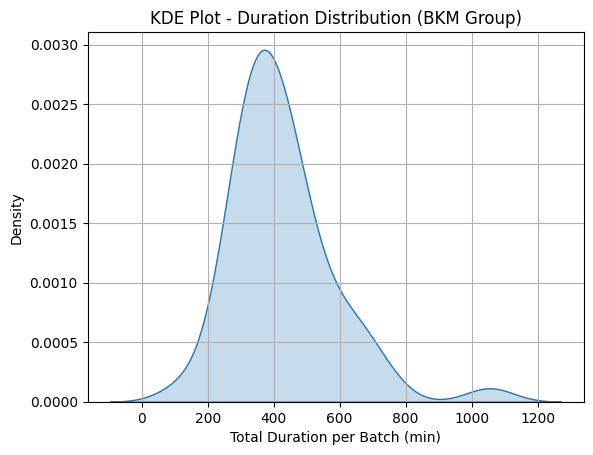

In [11]:
bkm_data = machine_batch_summary[machine_batch_summary['machine_group'] == 'BKM']

sns.kdeplot(bkm_data['duration_min'], fill=True)
plt.title('KDE Plot - Duration Distribution (BKM Group)')
plt.xlabel('Total Duration per Batch (min)')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [17]:
def analyse_machine_group(group_name, lower_pct=None, upper_pct=None):
    group_data = machine_batch_summary[machine_batch_summary['machine_group'] == group_name]
    durations = group_data['duration_min']

    # Apply optional percentile filtering
    if lower_pct is not None and upper_pct is not None:
        q_low = durations.quantile(lower_pct)
        q_high = durations.quantile(upper_pct)
        filtered = durations[(durations >= q_low) & (durations <= q_high)]
    else:
        filtered = durations

    # Stats
    mean_val = filtered.mean()
    std_val = filtered.std()

    # KDE plot
    plt.figure(figsize=(6, 3))
    sns.kdeplot(filtered, fill=True)
    plt.title(f'KDE - {group_name} (Filtered: {lower_pct}-{upper_pct})')
    plt.xlabel('Duration (min)')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

    print(f"{group_name} Mean: {mean_val:.2f} min")
    print(f"{group_name} Std Dev: {std_val:.2f} min\n")


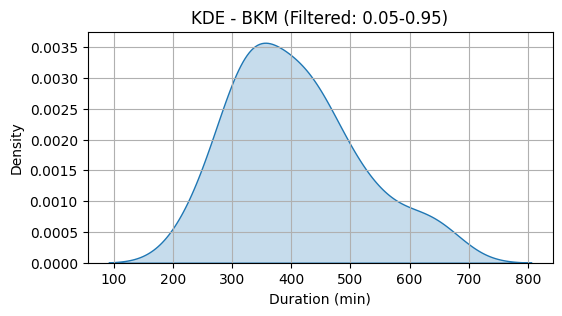

BKM Mean: 406.53 min
BKM Std Dev: 106.49 min



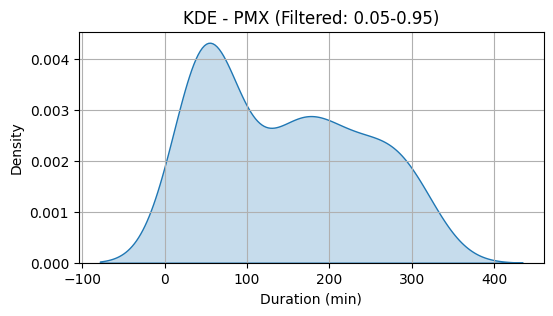

PMX Mean: 144.61 min
PMX Std Dev: 92.69 min



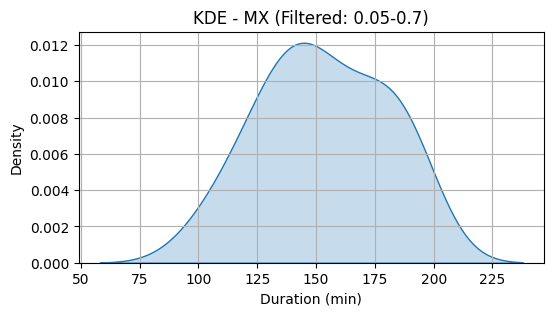

MX Mean: 153.05 min
MX Std Dev: 26.60 min



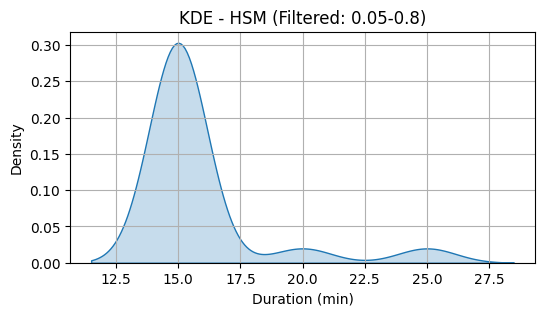

HSM Mean: 15.87 min
HSM Std Dev: 2.57 min



In [26]:
analyse_machine_group('BKM', 0.05, 0.95)
analyse_machine_group('PMX', 0.05, 0.95)
analyse_machine_group('MX', 0.05, 0.7)
analyse_machine_group('HSM', 0.05, 0.8)

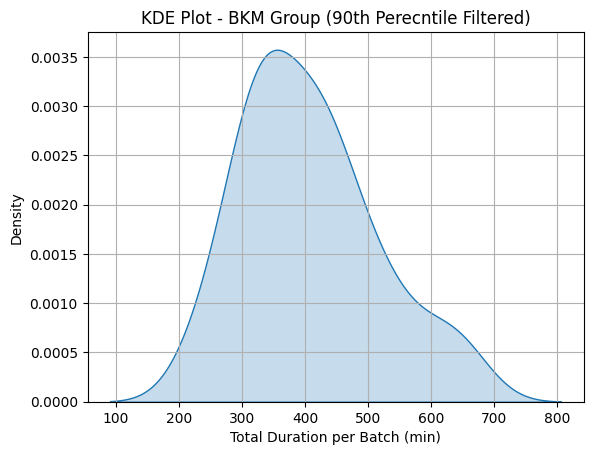

Mean (IQR): 406.53 minutes
Standard Deviation (IQR): 106.49 minutes


In [15]:
# Filter for BKM machine group
bkm_data = machine_batch_summary[machine_batch_summary['machine_group'] == 'BKM']

# Extract 5t2h and 95th percentiles
q1 = bkm_data['duration_min'].quantile(0.05)
q3 = bkm_data['duration_min'].quantile(0.95)

# Filter data within IQR
bkm_iqr = bkm_data[(bkm_data['duration_min'] >= q1) & (bkm_data['duration_min'] <= q3)]

# Plot KDE
sns.kdeplot(bkm_iqr['duration_min'], fill=True)
plt.title('KDE Plot - BKM Group (90th Perecntile Filtered)')
plt.xlabel('Total Duration per Batch (min)')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Calculate mean and standard deviation of the IQR-filtered data
mean_iqr = bkm_iqr['duration_min'].mean()
std_iqr = bkm_iqr['duration_min'].std()

print(f"Mean (IQR): {mean_iqr:.2f} minutes")
print(f"Standard Deviation (IQR): {std_iqr:.2f} minutes")